In [1]:
import re
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.font_manager as fm

In [2]:
start_date = "2004-01-01"
end_date = "2024-11-22"

In [3]:
import pandas as pd

# GCSファイルのパスを設定
file_path = 'gs://alternativedataanalysis_rd/BLOOMBERG/Sector Index.csv'

# gcsfsを使用してGCS上のCSVファイルを読み込む
df = pd.read_csv(file_path)

# 'Date'列をインデックスに設定し、変更を適用
df.set_index('Date', inplace=True)

# 最後の2行を削除
df = df.iloc[:-2]

# データの最初の数行を出力し、確認
print(df.head())



          S5INFT Index  S5TELS Index  S5FINL Index  S5UTIL Index  \
Date                                                               
2004/1/2        322.66        111.64        377.82        118.34   
2004/1/5        331.10        115.16        380.89        118.34   
2004/1/6        332.71        116.36        381.19        118.03   
2004/1/7        335.54        115.71        381.73        118.93   
2004/1/8        342.02        117.36        382.76        118.91   

          S5INDU Index  S5CONS Index  S5ENRS Index  S5HLTH Index  \
Date                                                               
2004/1/2        249.01        221.59        222.89        351.22   
2004/1/5        251.93        222.16        227.79        352.97   
2004/1/6        251.08        222.79        226.66        353.20   
2004/1/7        251.58        221.77        224.59        355.97   
2004/1/8        253.24        221.46        224.96        354.42   

          S5COND Index  S5MATR Index  S5RLST I

In [4]:
df

,S5INFT Index,S5TELS Index,S5FINL Index,S5UTIL Index,S5INDU Index,S5CONS Index,S5ENRS Index,S5HLTH Index,S5COND Index,S5MATR Index,S5RLST Index
Date,,,,,,,,,,,
2004/1/2,322.66,111.64,377.82,118.34,249.01,221.59,222.89,351.22,246.680,164.33,99.39
2004/1/5,331.10,115.16,380.89,118.34,251.93,222.16,227.79,352.97,248.640,167.45,99.57
2004/1/6,332.71,116.36,381.19,118.03,251.08,222.79,226.66,353.20,249.780,165.90,100.16
2004/1/7,335.54,115.71,381.73,118.93,251.58,221.77,224.59,355.97,250.720,165.17,99.36
2004/1/8,342.02,117.36,382.76,118.91,253.24,221.46,224.96,354.42,250.660,166.99,100.19
...,...,...,...,...,...,...,...,...,...,...,...
2024/7/17,4363.62,303.33,729.29,356.08,1070.81,843.66,713.37,1754.45,1544.316,578.65,256.58
2024/7/18,4353.79,302.45,719.93,355.85,1062.96,839.60,715.75,1714.22,1524.554,572.76,254.50
2024/7/19,4298.44,301.87,712.71,356.24,1056.59,836.42,706.51,1722.79,1512.321,567.76,254.19


In [ ]:
# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.15.2
#   kernelspec:
#     display_name: Python 3 (ipykernel) (Local)
#     language: python
#     name: conda-root-py
# ---

# %% [markdown]
# ### 吸収率（Absorption Ratio）と資産の中心性（Asset Centrality）

# %% [markdown]
# - 混雑した取引（Crowded Trades）: セクターローテーションとファクタータイミングへの影響
#     - https://www.northinfo.com/documents/823.pdf

# %%
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# %%
def create_price_df(tickers, df_bbg, remove_nan=True, verbose=True):
    """
    指定されたティッカーの価格データフレームを作成する関数。
    
    パラメータ:
    - tickers: 取得する資産のティッカーリスト
    - df_bbg: Bloombergデータのデータフレーム
    - remove_nan: NaNを削除するかどうか（デフォルトはTrue）
    - verbose: 処理情報を表示するか（デフォルトはTrue）
    
    戻り値:
    - 指定されたティッカーのデータを含むデータフレーム
    """
    df = df_bbg.copy()
    df.index = pd.to_datetime(df.index)
    
    if verbose:
        print("元の列:", df.columns)

    missing_tickers = [ticker for ticker in tickers if ticker not in df.columns]
    if missing_tickers:
        raise ValueError(f"データに存在しないティッカー: {missing_tickers}")

    df = df[tickers].copy()
    if remove_nan:
        df = df.dropna()

    if verbose:
        print("処理後のデータフレーム形状:", df.shape)
        print("処理後の列:", df.columns)
        
    return df


# 使用するセクター指数
assets_multi = [
    'S5INFT Index',  # S&P 500 情報技術
    'S5TELS Index',  # S&P 500 通信サービス
    'S5FINL Index',  # S&P 500 金融
    'S5UTIL Index',  # S&P 500 公益事業
    'S5INDU Index',  # S&P 500 資本財
    'S5CONS Index',  # S&P 500 生活必需品
    'S5ENRS Index',  # S&P 500 エネルギー
    'S5HLTH Index',  # S&P 500 ヘルスケア
    'S5COND Index',  # S&P 500 一般消費財
    'S5MATR Index',  # S&P 500 素材
    'S5RLST Index'   # S&P 500 不動産
]

# CSVからデータを読み込む
bbg_data = pd.read_csv("gs://alternativedataanalysis_rd/BLOOMBERG/Sector Index.csv", index_col=0)

# 価格データフレームを作成
prices_multi = create_price_df(assets_multi, bbg_data)

def calculate_absorption_ratio(asset_returns: pd.DataFrame, n_components: int = 2):
    """
    吸収率（Absorption Ratio）を計算する関数。
    
    パラメータ:
    - asset_returns: 資産のリターンデータフレーム
    - n_components: PCAの主成分数（デフォルトは2）
    
    戻り値:
    - 吸収率（PCAで説明される分散の合計）
    """
    covariance_matrix = np.cov(asset_returns, rowvar=False)
    pca = PCA(n_components=n_components)
    pca.fit(covariance_matrix)
    absorption_ratio = np.sum(pca.explained_variance_ratio_)
    return absorption_ratio

# 開始日とウィンドウサイズを設定
start_date = pd.Timestamp('2004-01-02')  # Timestamp に変換
window = 500  # 500日間のウィンドウ

# 計算結果を格納するリストを初期化
absorption_ratios = []

# 指定した期間をループし、吸収率を計算
for current_date in prices_multi.index[window-1:]:  # ウィンドウサイズに合わせた開始日
    if current_date >= start_date:
        # 過去500日間のリターンを取得
        returns = prices_multi.loc[:current_date].pct_change().tail(window).dropna()
        if returns.shape[0] == window:  # 十分なデータがある場合のみ計算
            ar = calculate_absorption_ratio(returns)
            absorption_ratios.append({'Date': current_date, 'Absorption_Ratio': ar})

# 結果をデータフレームに変換
absorption_ratios_df = pd.DataFrame(absorption_ratios)

# CSVに保存
absorption_ratios_df.to_csv("absorption_ratios.csv", index=False)




元の列: Index(['S5INFT Index', 'S5TELS Index', 'S5FINL Index', 'S5UTIL Index',
       'S5INDU Index', 'S5CONS Index', 'S5ENRS Index', 'S5HLTH Index',
       'S5COND Index', 'S5MATR Index', 'S5RLST Index'],
      dtype='object')
処理後のデータフレーム形状: (5173, 11)
処理後の列: Index(['S5INFT Index', 'S5TELS Index', 'S5FINL Index', 'S5UTIL Index',
       'S5INDU Index', 'S5CONS Index', 'S5ENRS Index', 'S5HLTH Index',
       'S5COND Index', 'S5MATR Index', 'S5RLST Index'],
      dtype='object')


In [ ]:
import pandas as pd


df1 = pd.read_csv('gs://alternativedataanalysis_rd/BLOOMBERG/MSCI Index.csv', header=None)  # 使用 header=None 读取没有列名的 CSV


df1.columns = ['Date', 'MSCI']


df1.set_index('Date', inplace=True)


print(df1.head())


In [ ]:
import pandas as pd


df1 = pd.read_csv('gs://alternativedataanalysis_rd/BLOOMBERG/MSCI Index.csv', header=None)
df1.columns = ['Date', 'MSCI']
df1.set_index('Date', inplace=True)


df1.index = pd.to_datetime(df1.index)


df1_filtered = df1[df1.index >= '2004-01-02']


merged_df = pd.merge(absorption_ratios_df, df1_filtered, left_on='Date', right_index=True, how='inner')


print(merged_df.head())


merged_df.to_csv("merged_data.csv", index=True)


In [ ]:
merged_df.set_index('Date',inplace=True)
merged_df

In [ ]:
# IEFデータ（iShares 7-10 Year Treasury Bond ETF）をダウンロード
ief_data = yf.download('IEF', start=start_date, end=end_date, interval="1d")
ief_adj_close = ief_data[['Close']]
ief_adj_close.columns = ['IEF_Adj_Close']

# SPYデータ（S&P500 ETF）をダウンロード
spy_data = yf.download('SPY', start=start_date, end=end_date, interval="1d")
spy_adj_close = spy_data[['Close']]
spy_adj_close.columns = ['SPY_Adj_Close']

# **IEFとSPYのデータを統合**
market_data = pd.concat([ief_adj_close, spy_adj_close], axis=1)

# 日次リターンを計算
market_data['SPY_Returns'] = market_data['SPY_Adj_Close'].pct_change()
market_data['IEF_Returns'] = market_data['IEF_Adj_Close'].pct_change()

# **SPYとIEFのリターンを1日ずらす**
market_data['SPY_Returns_Lagged'] = market_data['SPY_Returns'].shift(1)
market_data['IEF_Returns_Lagged'] = market_data['IEF_Returns'].shift(1)

# **12ヶ月のローリング相関（252取引日ウィンドウ）を計算**
market_data['Stock_Bond_Correlation_Lagged'] = (
    market_data['SPY_Returns_Lagged']
    .rolling(window=126)
    .corr(market_data['IEF_Returns_Lagged'])
)

# 欠損値を削除
market_data.dropna(inplace=True)

# **吸収率（Absorption Ratio）+ MSCIデータ + 金融市場データを統合**
final_df = pd.merge(merged_df, market_data, left_index=True, right_index=True, how='inner')


In [ ]:
final_df

In [ ]:
# 15日移動平均（1日先行）
final_df['MA_15'] = final_df['Absorption_Ratio'].shift(1).rolling(window=15).mean()

# 252日移動平均（1日先行）
final_df['MA_252'] = final_df['Absorption_Ratio'].shift(1).rolling(window=252).mean()

# 標準偏差を計算（252日間の吸収比率の標準偏差、1日先行）
final_df['Std_Dev'] = final_df['Absorption_Ratio'].shift(1).rolling(window=252).std()

# 差分を計算
final_df['Difference'] = final_df['MA_15'] - final_df['MA_252']

# 標準化ピーク（尖度）を計算
final_df['1_Sigma'] = final_df['Difference'] / final_df['Std_Dev']


In [ ]:
final_df

In [ ]:
import matplotlib.pyplot as plt

# 図の作成と二重Y軸の設定
fig, ax1 = plt.subplots(figsize=(12, 6))

# '1_Sigma' の曲線を描画（左側Y軸）
ax1.plot(final_df.index, final_df['1_Sigma'], label='1_Sigma', color='blue', linewidth=1.5)
ax1.set_xlabel('日付')
ax1.set_ylabel('1_Sigma', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# 第二のY軸（右側Y軸）を作成
ax2 = ax1.twinx()
ax2.plot(final_df.index, final_df['MSCI'], label='MSCI', color='red', linewidth=1.5, linestyle='dashed')
ax2.set_ylabel('MSCI', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# タイトルと凡例を追加
plt.title('1_Sigma と MSCI の比較')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# X軸の目盛りを回転し、可読性を向上
plt.xticks(rotation=45)

# グラフを表示
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# final_dfをコピーして元のデータを変更しないようにする
df_plot = final_df.copy()

# **株式エクスポージャーの設定**
df_plot['Stock_Exposure'] = 0.5  # デフォルト値
df_plot.loc[df_plot['1_Sigma'] > 1, 'Stock_Exposure'] = 0
df_plot.loc[df_plot['1_Sigma'] < -1, 'Stock_Exposure'] = 1

# **2014年以降のデータを抽出**
df_plot = df_plot[df_plot.index >= '2014-01-01']

# **二重Y軸のグラフを作成**
fig, ax1 = plt.subplots(figsize=(14, 7))

# 左側Y軸：株式エクスポージャー率
ax1.set_ylabel('株式エクスポージャー率', color='blue')
ax1.plot(df_plot.index, df_plot['Stock_Exposure'], color='blue', label='株式エクスポージャー率', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# 右側Y軸：MSCI指数
ax2 = ax1.twinx()  # X軸を共有する第2のY軸を作成
ax2.set_ylabel('MSCI指数', color='orange')
ax2.plot(df_plot.index, df_plot['MSCI'], color='orange', label='MSCI指数', linewidth=1.5, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='orange')

# **タイトルと凡例**
plt.title('株式エクスポージャー率 vs MSCI指数（2014年以降）', fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# **X軸の目盛りを回転して可読性を向上**
plt.xticks(rotation=45)

# **グラフを表示**
plt.show()




In [ ]:
df_plot

combined_data 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **确保数据框名称为 df_plot**
combined_data = df_plot.copy()

# **初始化本金为 100 万**
initial_capital = 1_000_000

# **资产配置：60% 股票，40% 债券**
combined_data['Stock_Weight'] = 0.6
combined_data['Bond_Weight'] = 0.4

# **计算每月最后一个交易日**
combined_data['Last_Trading_Day_Of_Month'] = combined_data.index.to_series().groupby(combined_data.index.to_period('M')).idxmax()

# **计算每月的第一个交易日进行再平衡**
rebalance_dates = combined_data['Last_Trading_Day_Of_Month'].drop_duplicates().shift(1).dropna()
rebalance_dates = rebalance_dates.apply(lambda x: x + pd.offsets.MonthBegin(1))  # 确保是下个月的第一个交易日

# **初始化投资组合资金**
portfolio_value = initial_capital

# **计算初始持仓份额**
stock_shares = portfolio_value * 0.6 / combined_data['SPY_Adj_Close'].iloc[0]
bond_shares = portfolio_value * 0.4 / combined_data['IEF_Adj_Close'].iloc[0]

# **存储投资组合值**
combined_data['Portfolio_Value'] = np.nan  # 用 NaN 避免数据类型错误

# **每月的再平衡**
for date in combined_data.index:
    if date in rebalance_dates.values:
        # 计算上个月月末的投资组合总值
        portfolio_value = stock_shares * combined_data.loc[date, 'SPY_Adj_Close'] + bond_shares * combined_data.loc[date, 'IEF_Adj_Close']
        
        # 重新计算股票和债券的数量（保持60/40比例）
        stock_shares = portfolio_value * 0.6 / combined_data.loc[date, 'SPY_Adj_Close']
        bond_shares = portfolio_value * 0.4 / combined_data.loc[date, 'IEF_Adj_Close']
    
    # 计算当天的投资组合价值
    portfolio_value = stock_shares * combined_data.loc[date, 'SPY_Adj_Close'] + bond_shares * combined_data.loc[date, 'IEF_Adj_Close']
    
    # 更新投资组合的总值
    combined_data.loc[date, 'Portfolio_Value'] = portfolio_value

# **绘制投资组合总值的变化图**
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Portfolio_Value'], label='Portfolio Value', color='blue', linewidth=1.5)
plt.title('Portfolio Value Over Time\n(Rebalanced on First Trading Day of Each Month Using Last Month End Value)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()




/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12457 (\N{KATAKANA LETTER SMALL O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(b

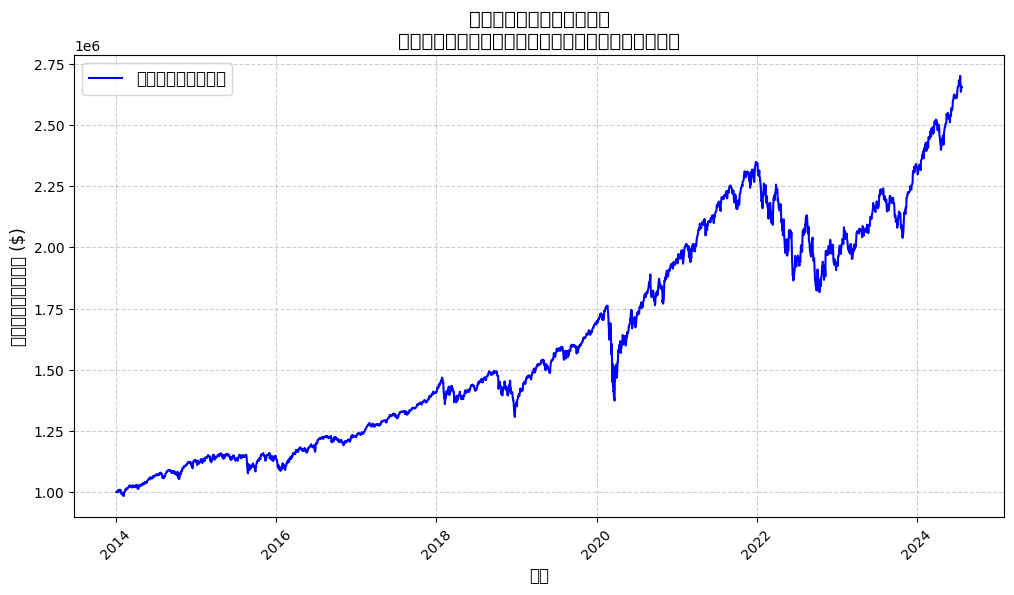

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **データフレーム名が df_plot であることを確認**
combined_data = df_plot.copy()

# **初期資本を 100万ドルに設定**
initial_capital = 1_000_000

# **資産配分：株式60%、債券40%**
combined_data['Stock_Weight'] = 0.6
combined_data['Bond_Weight'] = 0.4

# **毎月の最終取引日を計算**
combined_data['Last_Trading_Day_Of_Month'] = combined_data.index.to_series().groupby(combined_data.index.to_period('M')).idxmax()

# **毎月の最初の取引日にリバランス**
rebalance_dates = combined_data['Last_Trading_Day_Of_Month'].drop_duplicates().shift(1).dropna()
rebalance_dates = rebalance_dates.apply(lambda x: x + pd.offsets.MonthBegin(1))  # 翌月の最初の取引日を確保

# **ポートフォリオの初期値を設定**
portfolio_value = initial_capital

# **初期保有株数を計算**
stock_shares = portfolio_value * 0.6 / combined_data['SPY_Adj_Close'].iloc[0]
bond_shares = portfolio_value * 0.4 / combined_data['IEF_Adj_Close'].iloc[0]

# **ポートフォリオの価値を保存**
combined_data['Portfolio_Value'] = np.nan  # データ型エラーを防ぐためNaNを使用

# **毎月のリバランス**
for date in combined_data.index:
    if date in rebalance_dates.values:
        # 前月末のポートフォリオ価値を計算
        portfolio_value = stock_shares * combined_data.loc[date, 'SPY_Adj_Close'] + bond_shares * combined_data.loc[date, 'IEF_Adj_Close']
        
        # 株式と債券の数量を再計算（60/40の割合を維持）
        stock_shares = portfolio_value * 0.6 / combined_data.loc[date, 'SPY_Adj_Close']
        bond_shares = portfolio_value * 0.4 / combined_data.loc[date, 'IEF_Adj_Close']
    
    # 当日のポートフォリオ価値を計算
    portfolio_value = stock_shares * combined_data.loc[date, 'SPY_Adj_Close'] + bond_shares * combined_data.loc[date, 'IEF_Adj_Close']
    
    # ポートフォリオの総価値を更新
    combined_data.loc[date, 'Portfolio_Value'] = portfolio_value

# **ポートフォリオ価値の推移をプロット**
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Portfolio_Value'], label='ポートフォリオ価値', color='blue', linewidth=1.5)
plt.title('ポートフォリオ価値の推移\n（月末値を使用し、毎月最初の取引日でリバランス）', fontsize=14)
plt.xlabel('日付', fontsize=12)
plt.ylabel('ポートフォリオ価値 ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()



In [ ]:
####ポートフォリオ価値の推移\n(株式エクスポージャーの変化に基づくリバランス)

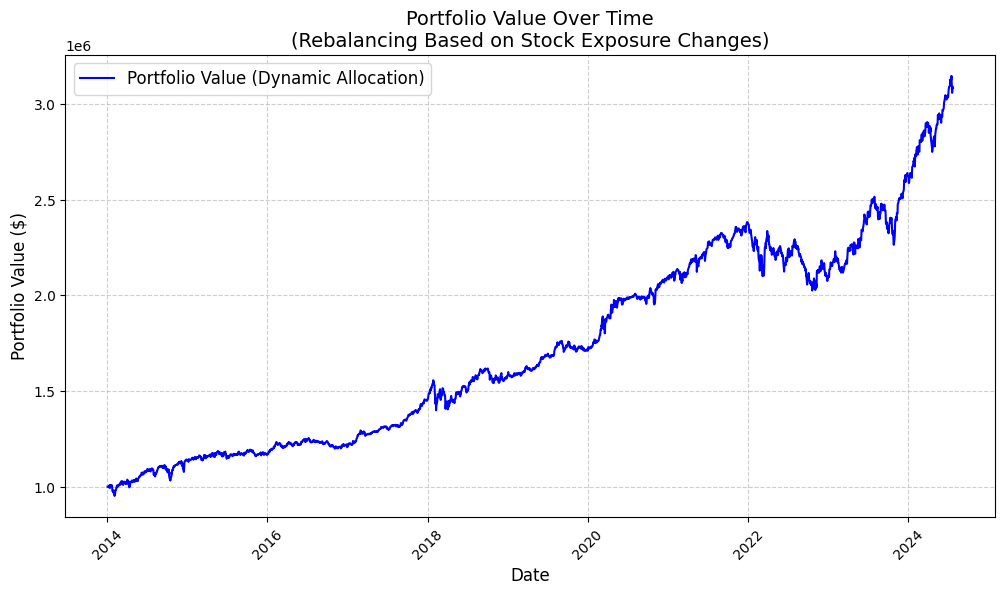

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **df_plotをコピーして新しいデータフレームを作成**
combined_data3 = df_plot.copy()

# **初期資本を 100万ドルに設定**
initial_capital = 1_000_000

# **ポートフォリオの価値を保存**
combined_data3['Portfolio_Value'] = np.nan

# **ポートフォリオの初期値を設定**
portfolio_value = initial_capital

# **保有株数を計算：最初のStock_Exposureに基づいて株式と債券の割合を設定**
stock_shares = portfolio_value * combined_data3['Stock_Exposure'].iloc[0] / combined_data3['SPY_Adj_Close'].iloc[0]  # 株式割合に基づく
bond_shares = portfolio_value * (1 - combined_data3['Stock_Exposure'].iloc[0]) / combined_data3['IEF_Adj_Close'].iloc[0]  # 債券割合に基づく

# **Stock_Exposureの変化がある場合にダイナミック・リバランスを実施**
for date in combined_data3.index:
    # 現在の株式・債券の割合を取得
    stock_weight = combined_data3.loc[date, 'Stock_Exposure']  # 現在の株式割合
    bond_weight = 1 - stock_weight  # 現在の債券割合
    
    # 当日のポートフォリオの総価値を計算
    portfolio_value = stock_shares * combined_data3.loc[date, 'SPY_Adj_Close'] + bond_shares * combined_data3.loc[date, 'IEF_Adj_Close']
    
    # ポートフォリオの総価値を更新
    combined_data3.loc[date, 'Portfolio_Value'] = portfolio_value
    
    # リバランスの必要性をチェック：株式割合が変更された場合のみ実施
    if date > combined_data3.index[0]:  # 最初の日付は除外
        # 前日の株式割合を取得（KeyErrorを回避するため）
        previous_stock_weight = combined_data3.loc[:date - pd.Timedelta(days=1), 'Stock_Exposure'].iloc[-1]
        
        # 株式割合が変化した場合のみリバランス
        if stock_weight != previous_stock_weight:
            # 新しい割合に基づいて株式・債券の保有数を再計算
            stock_shares = portfolio_value * stock_weight / combined_data3.loc[date, 'SPY_Adj_Close']
            bond_shares = portfolio_value * bond_weight / combined_data3.loc[date, 'IEF_Adj_Close']

plt.figure(figsize=(12, 6))
plt.plot(combined_data3.index, combined_data3['Portfolio_Value'], label='Portfolio Value (Dynamic Allocation)', color='blue', linewidth=1.5)

plt.title('Portfolio Value Over Time\n(Rebalancing Based on Stock Exposure Changes)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

plt.show()



In [ ]:
# 累積最高値を計算
combined_data3['Cumulative_Max'] = combined_data3['Portfolio_Value'].cummax()

# ドローダウンを計算
combined_data3['Drawdown'] = (combined_data3['Portfolio_Value'] - combined_data3['Cumulative_Max']) / combined_data3['Cumulative_Max']

# 最大ドローダウンとその発生日時を取得
max_drawdown = combined_data3['Drawdown'].min()
max_drawdown_date = combined_data3['Drawdown'].idxmin()

print(f"最大ドローダウン: {max_drawdown:.2%}")  
print(f"最大ドローダウン発生日: {max_drawdown_date}")



最大ドローダウン: -15.02%
最大ドローダウン発生日: 2022-10-20 00:00:00


In [ ]:
# インデックスが日付形式であることを確認
combined_data3.index = pd.to_datetime(combined_data3.index)

# 年を抽出
combined_data3['Year'] = combined_data3.index.year

# 各年のリターンを計算
annual_returns = combined_data3.groupby('Year')['Portfolio_Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)

# 年次リターンを表示
print(annual_returns)



Year
2014    0.135460
2015    0.026189
2016    0.028700
2017    0.192327
2018    0.084568
2019    0.078019
2020    0.221499
2021    0.138973
2022   -0.117522
2023    0.255603
2024    0.179081
Name: Portfolio_Value, dtype: float64


In [ ]:
#####相関係数を追加

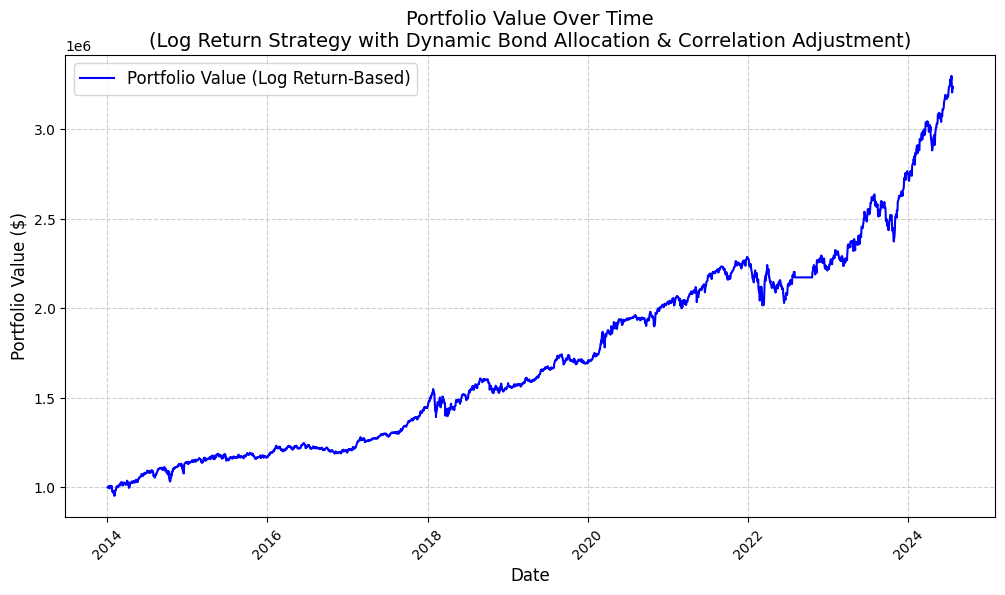

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **df_plotをコピーして新しいデータフレームを作成**
combined_data4 = df_plot.copy()

# **初期資本を設定**
initial_capital = 1_000_000

# **Bond_Signal 列を計算**
combined_data4['Bond_Signal'] = np.where(combined_data4['Stock_Bond_Correlation_Lagged'] < 0, 1, 0)

# **対数リターン (log return) を計算**
combined_data4['log_return_SPY'] = np.log(combined_data4['SPY_Adj_Close'] / combined_data4['SPY_Adj_Close'].shift(1))
combined_data4['log_return_IEF'] = np.log(combined_data4['IEF_Adj_Close'] / combined_data4['IEF_Adj_Close'].shift(1))

# **ポートフォリオの日次対数リターンを計算**
combined_data4['Portfolio_Log_Return'] = (
    combined_data4['Stock_Exposure'] * combined_data4['log_return_SPY'] + 
    (1 - combined_data4['Stock_Exposure']) * combined_data4['log_return_IEF'] * combined_data4['Bond_Signal']
)

# **累積リターンを計算**
combined_data4['Cumulative_Log_Return'] = combined_data4['Portfolio_Log_Return'].cumsum()

# **ポートフォリオ価値を計算**
combined_data4['Portfolio_Value'] = initial_capital * np.exp(combined_data4['Cumulative_Log_Return'])

# **ポートフォリオ価値の推移をプロット**
plt.figure(figsize=(12, 6))
plt.plot(combined_data4.index, combined_data4['Portfolio_Value'], label='Portfolio Value (Log Return-Based)', color='blue', linewidth=1.5)

plt.title('Portfolio Value Over Time\n(Log Return Strategy with Dynamic Bond Allocation & Correlation Adjustment)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

plt.show()

In [ ]:
combined_data4.loc["2014-01-02", "Portfolio_Value"] = 1_000_000

In [ ]:
combined_data4

,Absorption_Ratio,MSCI,IEF_Adj_Close,SPY_Adj_Close,SPY_Returns,IEF_Returns,SPY_Returns_Lagged,IEF_Returns_Lagged,Stock_Bond_Correlation_Lagged,MA_15,...,Std_Dev,Difference,1_Sigma,Stock_Exposure,Bond_Signal,log_return_SPY,log_return_IEF,Portfolio_Log_Return,Cumulative_Log_Return,Portfolio_Value
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.859024,1752.57,79.351974,150.735626,-0.009584,0.003930,0.004733,-0.004515,0.007669,0.869387,...,0.033339,-0.085759,-2.572311,1.0,0,NaN,NaN,NaN,NaN,1.000000e+06
2014-01-03,0.859849,1751.81,79.304138,150.710922,-0.000164,-0.000603,-0.009584,0.003930,-0.006398,0.868228,...,0.033862,-0.086460,-2.553321,1.0,1,-0.000164,-0.000603,-0.000164,-0.000164,9.998361e+05
2014-01-06,0.859981,1747.33,79.527184,150.274124,-0.002898,0.002813,-0.000164,-0.000603,0.048063,0.867061,...,0.034361,-0.087171,-2.536936,1.0,0,-0.002902,0.002809,-0.002902,-0.003066,9.969383e+05
2014-01-07,0.858423,1758.52,79.654686,151.197067,0.006142,0.001603,-0.002898,0.002813,0.035350,0.865922,...,0.034845,-0.087855,-2.521309,1.0,0,0.006123,0.001602,0.006123,0.003057,1.003061e+06
2014-01-08,0.858334,1758.27,79.264343,151.230042,0.000218,-0.004900,0.006142,0.001603,0.034652,0.864696,...,0.035333,-0.088619,-2.508115,1.0,0,0.000218,-0.004912,0.000218,0.003275,1.003280e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-17,0.809682,5314.31,92.852943,553.374451,-0.014021,0.000842,0.005930,0.004437,0.235864,0.816712,...,0.032326,-0.077237,-2.389310,1.0,0,-0.014120,0.000841,-0.014120,1.179567,3.252964e+06
2024-07-18,0.809657,5271.74,92.589439,549.121826,-0.007685,-0.002838,-0.014021,0.000842,0.220435,0.815951,...,0.032702,-0.077545,-2.371219,1.0,0,-0.007715,-0.002842,-0.007715,1.171852,3.227965e+06
2024-07-19,0.809716,5236.31,92.296707,545.475342,-0.006641,-0.003162,-0.007685,-0.002838,0.220826,0.815245,...,0.033070,-0.077798,-2.352511,1.0,0,-0.006663,-0.003167,-0.006663,1.165189,3.206530e+06


In [ ]:
# インデックスが日付形式であることを確認
combined_data4.index = pd.to_datetime(combined_data4.index)

# 年を抽出
combined_data4['Year'] = combined_data4.index.year

# 各年のリターンを計算
annual_returns = combined_data4.groupby('Year')['Portfolio_Value'].apply(lambda x: x.iloc[-1] / x.iloc[0] - 1)

# 年次リターンを表示
print(annual_returns)



Year
2014    0.135159
2015    0.025655
2016    0.018480
2017    0.199342
2018    0.078056
2019    0.078019
2020    0.198674
2021    0.125719
2022   -0.020124
2023    0.240596
2024    0.179081
Name: Portfolio_Value, dtype: float64


In [ ]:
combined_data4

,Absorption_Ratio,MSCI,IEF_Adj_Close,SPY_Adj_Close,SPY_Returns,IEF_Returns,SPY_Returns_Lagged,IEF_Returns_Lagged,Stock_Bond_Correlation_Lagged,MA_15,...,Difference,1_Sigma,Stock_Exposure,Bond_Signal,log_return_SPY,log_return_IEF,Portfolio_Log_Return,Cumulative_Log_Return,Portfolio_Value,Year
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.859024,1752.57,79.351974,150.735626,-0.009584,0.003930,0.004733,-0.004515,0.007669,0.869387,...,-0.085759,-2.572311,1.0,0,NaN,NaN,NaN,NaN,1.000000e+06,2014
2014-01-03,0.859849,1751.81,79.304138,150.710922,-0.000164,-0.000603,-0.009584,0.003930,-0.006398,0.868228,...,-0.086460,-2.553321,1.0,1,-0.000164,-0.000603,-0.000164,-0.000164,9.998361e+05,2014
2014-01-06,0.859981,1747.33,79.527184,150.274124,-0.002898,0.002813,-0.000164,-0.000603,0.048063,0.867061,...,-0.087171,-2.536936,1.0,0,-0.002902,0.002809,-0.002902,-0.003066,9.969383e+05,2014
2014-01-07,0.858423,1758.52,79.654686,151.197067,0.006142,0.001603,-0.002898,0.002813,0.035350,0.865922,...,-0.087855,-2.521309,1.0,0,0.006123,0.001602,0.006123,0.003057,1.003061e+06,2014
2014-01-08,0.858334,1758.27,79.264343,151.230042,0.000218,-0.004900,0.006142,0.001603,0.034652,0.864696,...,-0.088619,-2.508115,1.0,0,0.000218,-0.004912,0.000218,0.003275,1.003280e+06,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-17,0.809682,5314.31,92.852943,553.374451,-0.014021,0.000842,0.005930,0.004437,0.235864,0.816712,...,-0.077237,-2.389310,1.0,0,-0.014120,0.000841,-0.014120,1.179567,3.252964e+06,2024
2024-07-18,0.809657,5271.74,92.589439,549.121826,-0.007685,-0.002838,-0.014021,0.000842,0.220435,0.815951,...,-0.077545,-2.371219,1.0,0,-0.007715,-0.002842,-0.007715,1.171852,3.227965e+06,2024
2024-07-19,0.809716,5236.31,92.296707,545.475342,-0.006641,-0.003162,-0.007685,-0.002838,0.220826,0.815245,...,-0.077798,-2.352511,1.0,0,-0.006663,-0.003167,-0.006663,1.165189,3.206530e+06,2024


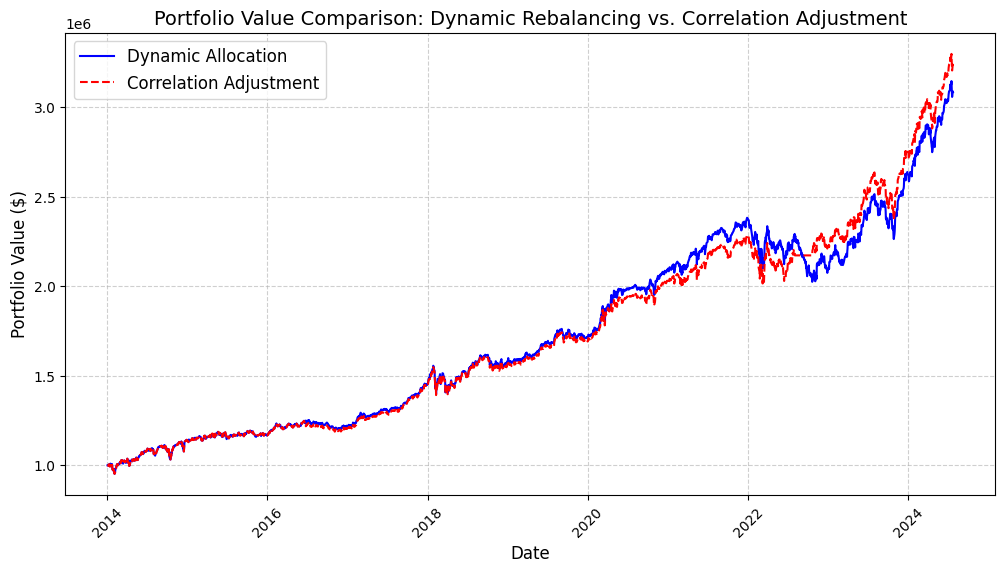

                         CAGR  Annual Volatility  Sharpe Ratio  Max Drawdown
Dynamic Allocation   0.112660           0.094499      1.192174     -0.150153
Log Return Strategy  0.117642           0.091749      1.282222     -0.118511


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# combined_data3 と combined_data4 がすでに存在すると仮定し、インデックスを日付形式に変換
combined_data3.index = pd.to_datetime(combined_data3.index)
combined_data4.index = pd.to_datetime(combined_data4.index)

# **バックテスト指標を計算する関数**
def calculate_performance_metrics(df, portfolio_column):
    df = df.copy()
    
    # 日次リターンを計算
    df['Daily_Return'] = df[portfolio_column].pct_change()
    
    # 年間複利成長率 (CAGR) を計算
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    cagr = (df[portfolio_column].iloc[-1] / df[portfolio_column].iloc[0]) ** (1 / total_years) - 1
    
    # 年間ボラティリティ (Annual Volatility) を計算
    annual_volatility = df['Daily_Return'].std() * np.sqrt(252)
    
    # シャープレシオ (Sharpe Ratio) を計算（無リスク利子率は0とする）
    sharpe_ratio = cagr / annual_volatility if annual_volatility > 0 else np.nan
    
    # 最大ドローダウン (Max Drawdown) を計算
    df['Cumulative_Max'] = df[portfolio_column].cummax()
    df['Drawdown'] = (df[portfolio_column] - df['Cumulative_Max']) / df['Cumulative_Max']
    max_drawdown = df['Drawdown'].min()
    
    return {
        "CAGR": cagr,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

# **combined_data3（動的リバランス戦略）のバックテスト指標を計算**
metrics_combined_data3 = calculate_performance_metrics(combined_data3, 'Portfolio_Value')

# **combined_data4（対数リターン戦略）のバックテスト指標を計算**
metrics_combined_data4 = calculate_performance_metrics(combined_data4, 'Portfolio_Value')

# **結果をまとめる**
performance_comparison = pd.DataFrame(
    [metrics_combined_data3, metrics_combined_data4], 
    index=['Dynamic Allocation', 'Log Return Strategy']
)

plt.figure(figsize=(12, 6))
plt.plot(combined_data3.index, combined_data3['Portfolio_Value'], label='Dynamic Allocation', color='blue', linewidth=1.5)
plt.plot(combined_data4.index, combined_data4['Portfolio_Value'], label='Correlation Adjustment', color='red', linestyle='dashed', linewidth=1.5)

plt.title('Portfolio Value Comparison: Dynamic Rebalancing vs. Correlation Adjustment', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

plt.show()
# **バックテスト指標の比較を表示**
print(performance_comparison)



In [ ]:
###相関係数

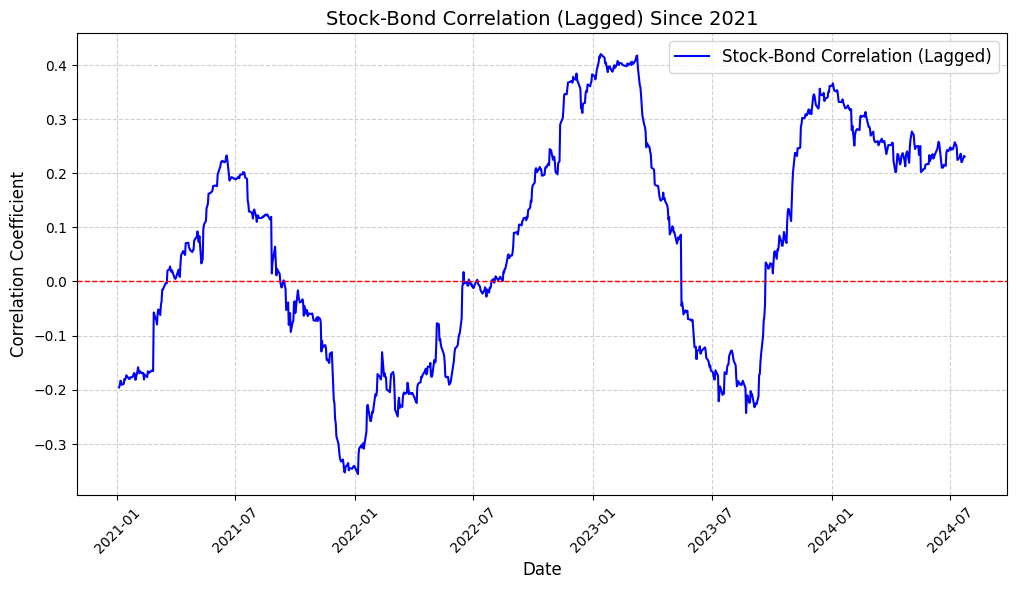

In [ ]:
import matplotlib.pyplot as plt

# インデックスを日付形式に変換
combined_data4.index = pd.to_datetime(combined_data4.index)

# 2021年以降のデータを抽出
correlation_2021 = combined_data4.loc[combined_data4.index >= "2021-01-01", "Stock_Bond_Correlation_Lagged"]

import matplotlib.pyplot as plt

# **Plot Stock-Bond Correlation Variations**
plt.figure(figsize=(12, 6))
plt.plot(correlation_2021.index, correlation_2021, label="Stock-Bond Correlation (Lagged)", color='blue', linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Add a reference line at y=0

plt.title("Stock-Bond Correlation (Lagged) Since 2021", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

# Display the graph
plt.show()




In [ ]:
import yfinance as yf

# 米国10年債利回りのデータを取得
us10y = yf.download("^TNX", start="2021-01-01", end="2024-11-22", interval="1d")["Close"]
us10y.name = "US10Y_Yield"

# combined_data4 に結合
combined_data4 = combined_data4.join(us10y)



[*********************100%***********************]  1 of 1 completed
